# Generative Adversarial Networks (GANs) using Keras on Tensorflow Backend
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [1]:
import numpy as np
import time
from numpy.random import randint, randn
from keras.datasets.mnist import load_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Discriminator
The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake.

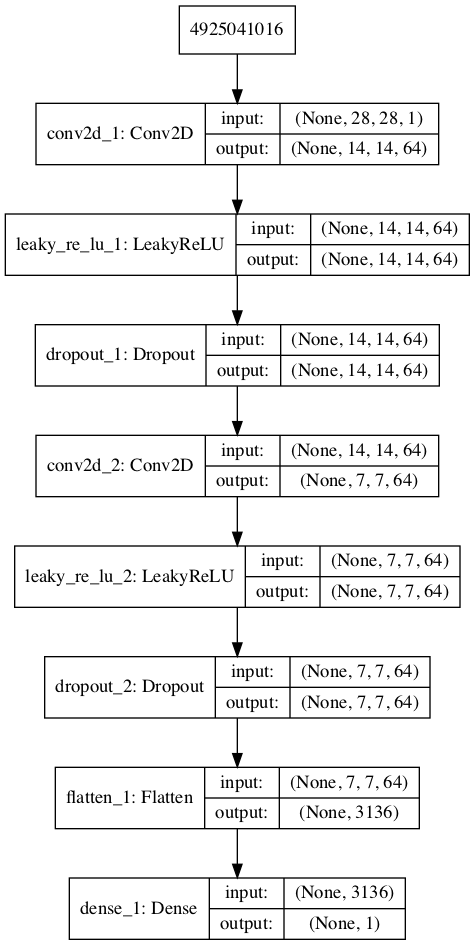

In [2]:
class Discriminator:
    def __init__(self, in_shape=(28, 28, 1)):
        self.model = self._create(in_shape)
    
    def _create(self, in_shape=(28, 28, 1)):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        # Compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model
    
    @staticmethod
    def generate_real_samples(dataset, n_samples):
        # Choose random instances
        ix = randint(0, dataset.shape[0], n_samples)

        # Retrieve selected images
        X = dataset[ix]

        # Generate 'real' class labels (0)
        y = np.zeros((n_samples, 1))

        return X, y

    @staticmethod
    def generate_fake_samples(n_samples):
        # Generate uniform random numbers in [0, 1]
        X = rand(28 * 28 * n_samples)

        # Reshape into a batch of grayscale images
        X = X.reshape((n_samples, 28, 28, 1))

        # Generate 'fake' class labels (1)
        y = np.ones((n_samples, 1))

        return X, y
    
    def train(self, dataset, n_iter=100, n_batch=256):
        half_batch = int(n_batch / 2)
        
        # Manually enumerate epochs
        for i in range(n_iter):
            # Get randomly selected 'real' samples
            X_real, y_real = self.generate_real_samples(dataset, half_batch)
            
            # Update discriminator on real samples
            _, real_acc = self.model.train_on_batch(X_real, y_real)
            
            # Generate 'fake' examples
            X_fake, y_fake = self.generate_fake_samples(half_batch)
            
            # Update discriminator on fake samples
            _, fake_acc = self.model.train_on_batch(X_fake, y_fake)
            
            # Summarize performance
            print('>%d real=%.0f%% fake=%.0f%%' % (i + 1, real_acc * 100, fake_acc * 100))

## Generator
The generator model is responsible for creating new, fake but plausible images of handwritten digits.
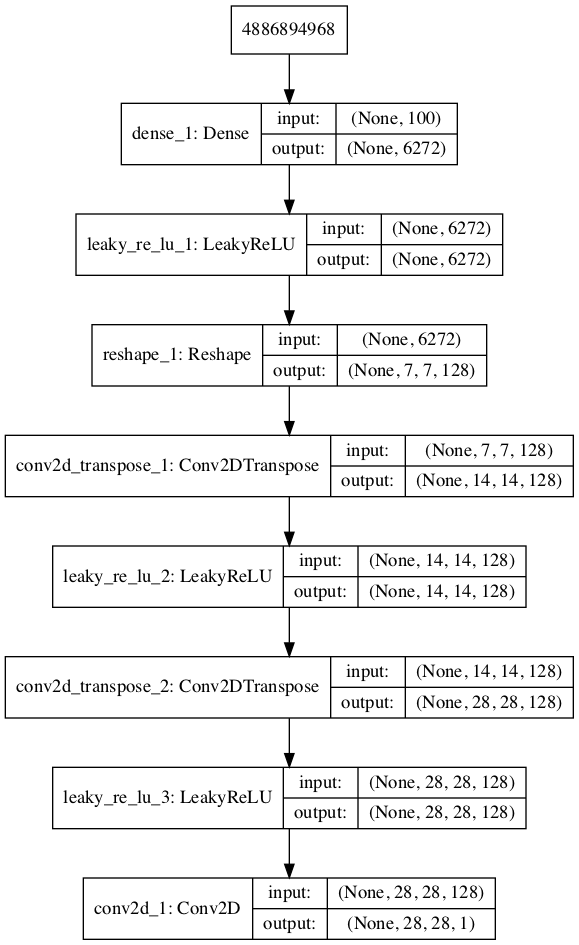

In [3]:
class Generator:
    def __init__(self, latent_dim = 100):
        self.model = self._create(latent_dim)
        
    def _create(self, latent_dim):
        model = Sequential()
        
        # Foundation for 7x7 image
        n_nodes = 128 * 7 * 7
        model.add(Dense(n_nodes, input_dim=latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((7, 7, 128)))
        
        # Upsample to 14x14
        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        
        # Upsample to 28x28
        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
        
        model.summary()
        
        return model
    
    @staticmethod
    def generate_latent_points(latent_dim, n_samples):
        # Generate points in the latent space
        x_input = randn(latent_dim * n_samples)

        # Reshape into a batch of inputs for the network
        x_input = x_input.reshape(n_samples, latent_dim)

        return x_input
    
    def generate_fake_samples(self, latent_dim, n_samples):
        # Generate points in latent space
        x_input = self.generate_latent_points(latent_dim, n_samples)
        
        # Predict outputs
        X = self.model.predict(x_input)
        
        # Create 'fake' class labels (1)
        y = np.ones((n_samples, 1))
        
        return X, y

## Composite model
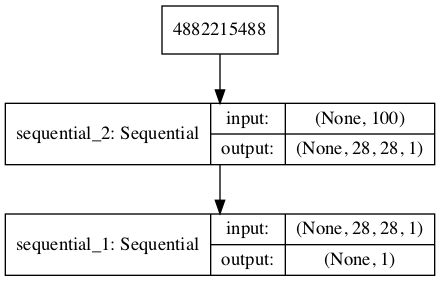

In [4]:
class GAN:
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator
        self.model = self._create(generator.model, discriminator.model)        
        
    def _create(self, generator_model, discriminator_model):
        # Make weights in the discriminator not trainable
        discriminator_model.trainable = False
        
        # Connect them
        model = Sequential()
        model.add(generator_model)
        model.add(discriminator_model)
        
        # Compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)
        model.summary()
        
        return model

    def train(self, latent_dim, n_epochs=100, n_batch=256):
        # Manually enumerate epochs
        for i in range(n_epochs):
            # Prepare points in latent space as input for the generator
            x_gan = self.generator.generate_latent_points(latent_dim, n_batch)
            
            # Create inverted labels for the fake samples
            y_gan = np.zeros((n_batch, 0))
            
            # Update the generator via the discriminator's error
            self.model.train_on_batch(x_gan, y_gan)
            
    def summarize_performance(self, epoch, dataset, latent_dim, n_samples = 100, n = 5):
        # Prepare real samples
        X_real, y_real = self.discriminator.generate_real_samples(dataset, n_samples)
        
        # Evaluate discriminator on real examples
        _, acc_real = self.discriminator.model.evaluate(X_real, y_real, verbose=0)
        
        # Prepare fake examples
        x_fake, y_fake = self.generator.generate_fake_samples(latent_dim, n_samples)
        
        # Evaluate discriminator on fake examples
        _, acc_fake = self.discriminator.model.evaluate(x_fake, y_fake, verbose=0)
        
        # Summarize discriminator performance
        print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
        
        # Plot images
        fig = plt.figure(figsize=(8, 8))
        for i in range(n * n):
            ax=fig.add_subplot(n, n, 1 + i)
            ax.imshow(x_fake[i, ..., 0], cmap='gray')
            plt.axis('off')
        fig.suptitle(f'Iteration {i}')
        plt.show()            

## Initialization
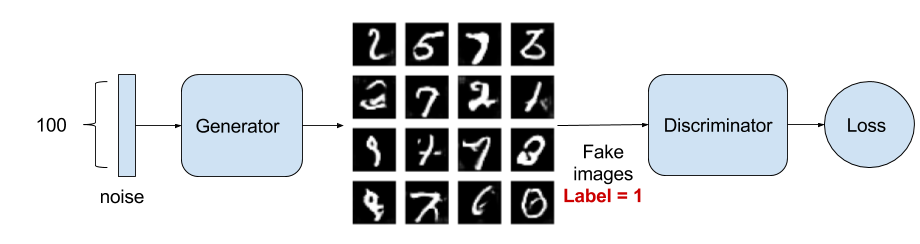

In [5]:
# Load dataset and expand dimensions
(x_train, _), (_, _) = load_data()
x_train = x_train[..., np.newaxis].astype(np.float32)

# Scale from [0,255] to [0,1]
x_train = x_train / 255.0

In [6]:
generator = Generator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 28, 28, 128)      

In [7]:
discriminator = Discriminator()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

In [8]:
gan = GAN(generator, discriminator)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


## Training
The weights in the generator model are updated based on the performance of the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

This defines the zero-sum or adversarial relationship between these two models.
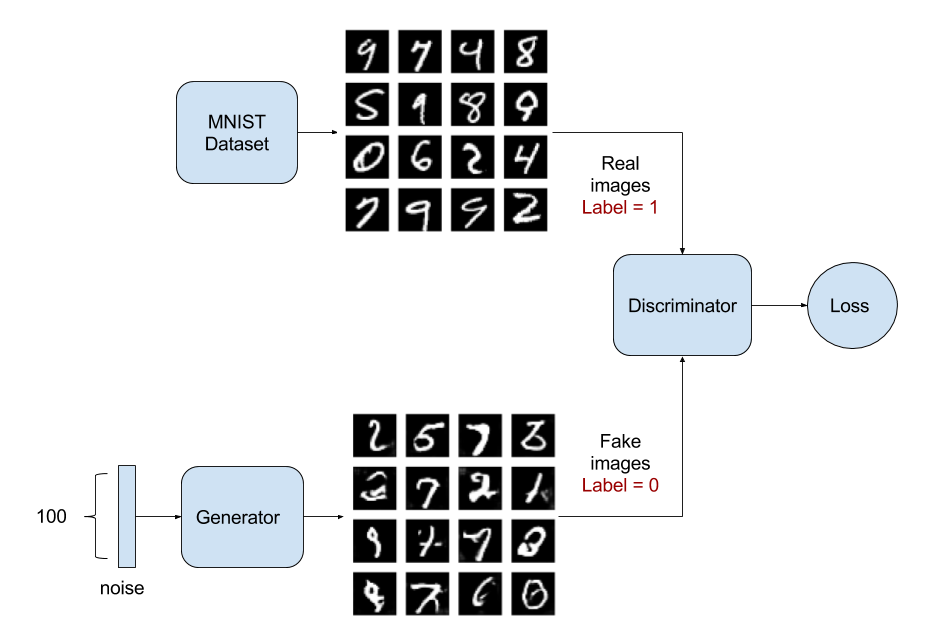

/home/luis.garcia/.virtualenvs/ai/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/luis.garcia/.virtualenvs/ai/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1; Disc loss = 0.671; Gen loss = 0.775
Epoch: 2; Disc loss = 0.681; Gen loss = 0.710
Epoch: 3; Disc loss = 0.707; Gen loss = 0.732
Epoch: 4; Disc loss = 0.694; Gen loss = 0.709
Epoch: 5; Disc loss = 0.691; Gen loss = 0.706
Epoch: 6; Disc loss = 0.691; Gen loss = 0.703
Epoch: 7; Disc loss = 0.695; Gen loss = 0.715
Epoch: 8; Disc loss = 0.683; Gen loss = 0.719
Epoch: 9; Disc loss = 0.695; Gen loss = 0.701
Epoch: 10; Disc loss = 0.686; Gen loss = 0.704
>Accuracy real: 53%, fake: 51%


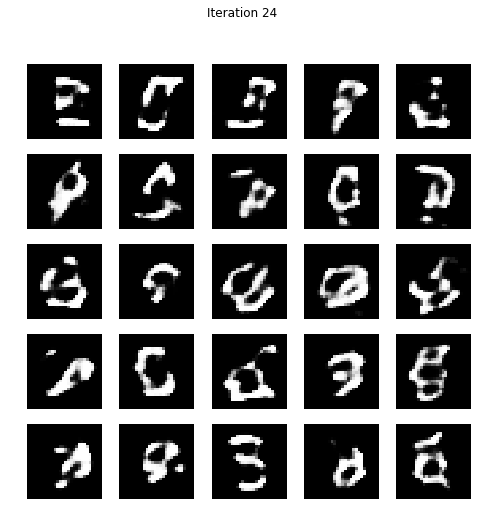

Epoch: 11; Disc loss = 0.683; Gen loss = 0.712
Epoch: 12; Disc loss = 0.690; Gen loss = 0.741
Epoch: 13; Disc loss = 0.678; Gen loss = 0.712
Epoch: 14; Disc loss = 0.692; Gen loss = 0.703
Epoch: 15; Disc loss = 0.686; Gen loss = 0.726
Epoch: 16; Disc loss = 0.699; Gen loss = 0.690
Epoch: 17; Disc loss = 0.680; Gen loss = 0.686
Epoch: 18; Disc loss = 0.679; Gen loss = 0.718
Epoch: 19; Disc loss = 0.683; Gen loss = 0.703
Epoch: 20; Disc loss = 0.692; Gen loss = 0.696
>Accuracy real: 64%, fake: 74%


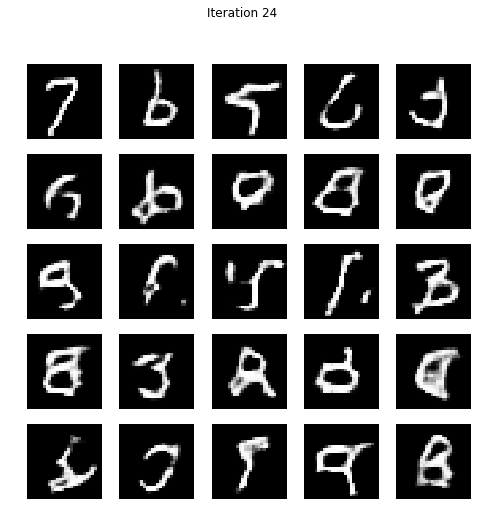

Epoch: 21; Disc loss = 0.689; Gen loss = 0.750
Epoch: 22; Disc loss = 0.688; Gen loss = 0.709
Epoch: 23; Disc loss = 0.686; Gen loss = 0.702
Epoch: 24; Disc loss = 0.685; Gen loss = 0.716
Epoch: 25; Disc loss = 0.679; Gen loss = 0.727
Epoch: 26; Disc loss = 0.696; Gen loss = 0.704
Epoch: 27; Disc loss = 0.690; Gen loss = 0.705
Epoch: 28; Disc loss = 0.687; Gen loss = 0.717
Epoch: 29; Disc loss = 0.689; Gen loss = 0.700
Epoch: 30; Disc loss = 0.678; Gen loss = 0.696
>Accuracy real: 77%, fake: 57%


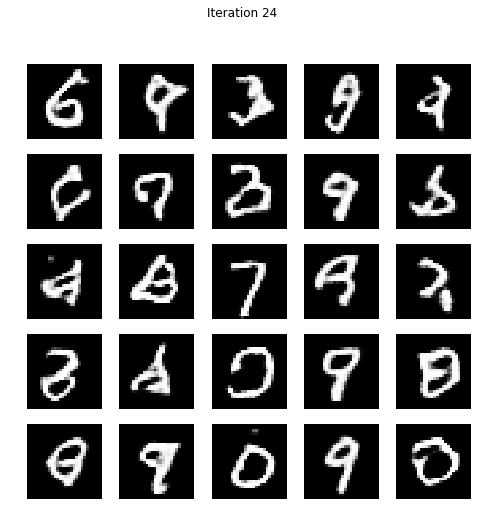

Epoch: 31; Disc loss = 0.680; Gen loss = 0.763
Epoch: 32; Disc loss = 0.687; Gen loss = 0.697
Epoch: 33; Disc loss = 0.684; Gen loss = 0.678
Epoch: 34; Disc loss = 0.689; Gen loss = 0.712
Epoch: 35; Disc loss = 0.689; Gen loss = 0.692
Epoch: 36; Disc loss = 0.689; Gen loss = 0.734
Epoch: 37; Disc loss = 0.694; Gen loss = 0.721
Epoch: 38; Disc loss = 0.693; Gen loss = 0.666
Epoch: 39; Disc loss = 0.687; Gen loss = 0.741
Epoch: 40; Disc loss = 0.686; Gen loss = 0.689
>Accuracy real: 83%, fake: 65%


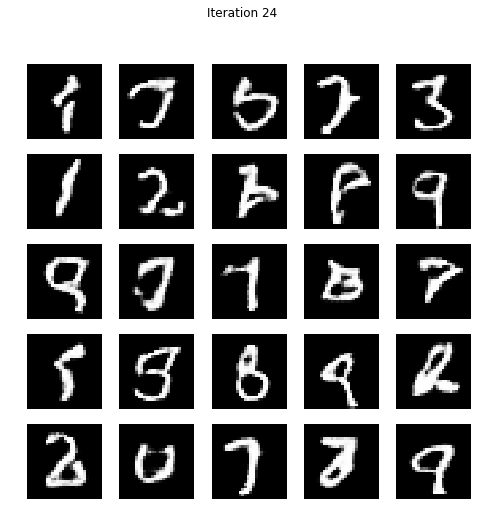

Epoch: 41; Disc loss = 0.688; Gen loss = 0.708
Epoch: 42; Disc loss = 0.676; Gen loss = 0.702
Epoch: 43; Disc loss = 0.686; Gen loss = 0.692
Epoch: 44; Disc loss = 0.697; Gen loss = 0.726
Epoch: 45; Disc loss = 0.697; Gen loss = 0.687
Epoch: 46; Disc loss = 0.685; Gen loss = 0.724
Epoch: 47; Disc loss = 0.682; Gen loss = 0.735
Epoch: 48; Disc loss = 0.684; Gen loss = 0.686
Epoch: 49; Disc loss = 0.696; Gen loss = 0.703
Epoch: 50; Disc loss = 0.687; Gen loss = 0.703
>Accuracy real: 37%, fake: 85%


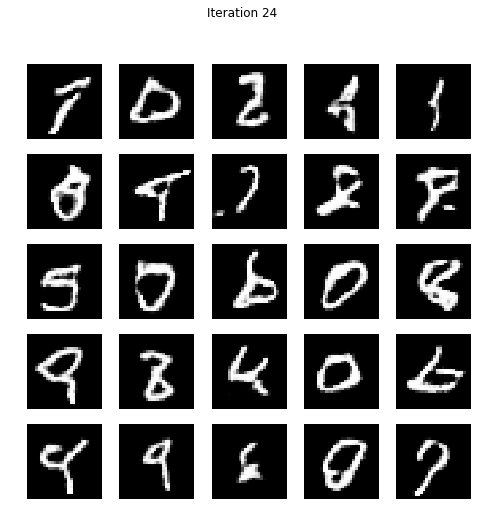

Epoch: 51; Disc loss = 0.687; Gen loss = 0.707
Epoch: 52; Disc loss = 0.690; Gen loss = 0.703
Epoch: 53; Disc loss = 0.688; Gen loss = 0.706
Epoch: 54; Disc loss = 0.692; Gen loss = 0.723
Epoch: 55; Disc loss = 0.697; Gen loss = 0.752
Epoch: 56; Disc loss = 0.686; Gen loss = 0.698
Epoch: 57; Disc loss = 0.682; Gen loss = 0.707
Epoch: 58; Disc loss = 0.688; Gen loss = 0.699
Epoch: 59; Disc loss = 0.682; Gen loss = 0.697
Epoch: 60; Disc loss = 0.687; Gen loss = 0.734
>Accuracy real: 10%, fake: 99%


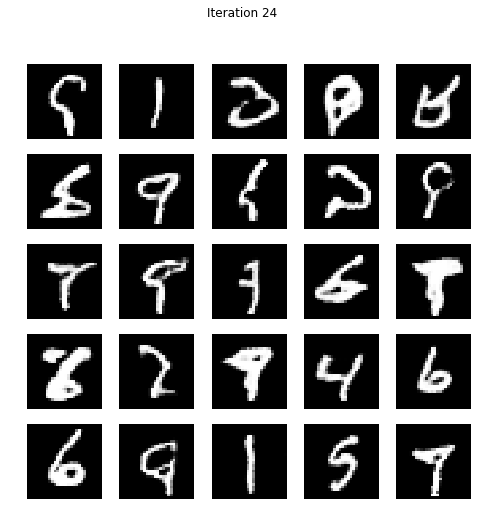

Epoch: 61; Disc loss = 0.679; Gen loss = 0.712
Epoch: 62; Disc loss = 0.688; Gen loss = 0.717
Epoch: 63; Disc loss = 0.689; Gen loss = 0.679
Epoch: 64; Disc loss = 0.681; Gen loss = 0.693
Epoch: 65; Disc loss = 0.691; Gen loss = 0.699
Epoch: 66; Disc loss = 0.674; Gen loss = 0.724
Epoch: 67; Disc loss = 0.682; Gen loss = 0.713
Epoch: 68; Disc loss = 0.695; Gen loss = 0.707
Epoch: 69; Disc loss = 0.694; Gen loss = 0.743
Epoch: 70; Disc loss = 0.692; Gen loss = 0.715
>Accuracy real: 17%, fake: 95%


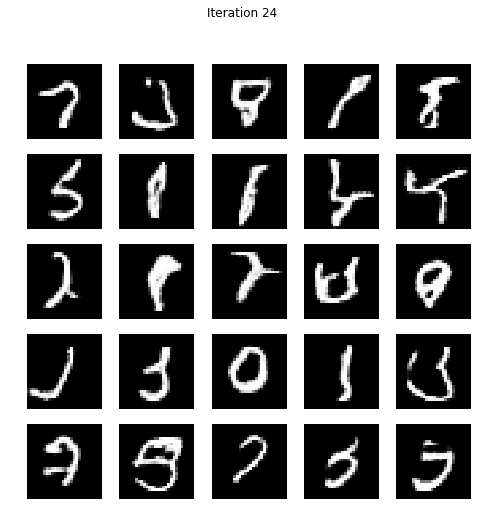

Epoch: 71; Disc loss = 0.700; Gen loss = 0.699
Epoch: 72; Disc loss = 0.693; Gen loss = 0.676
Epoch: 73; Disc loss = 0.695; Gen loss = 0.687
Epoch: 74; Disc loss = 0.687; Gen loss = 0.716
Epoch: 75; Disc loss = 0.690; Gen loss = 0.699
Epoch: 76; Disc loss = 0.699; Gen loss = 0.695
Epoch: 77; Disc loss = 0.690; Gen loss = 0.727
Epoch: 78; Disc loss = 0.692; Gen loss = 0.728
Epoch: 79; Disc loss = 0.693; Gen loss = 0.728
Epoch: 80; Disc loss = 0.688; Gen loss = 0.704
>Accuracy real: 25%, fake: 90%


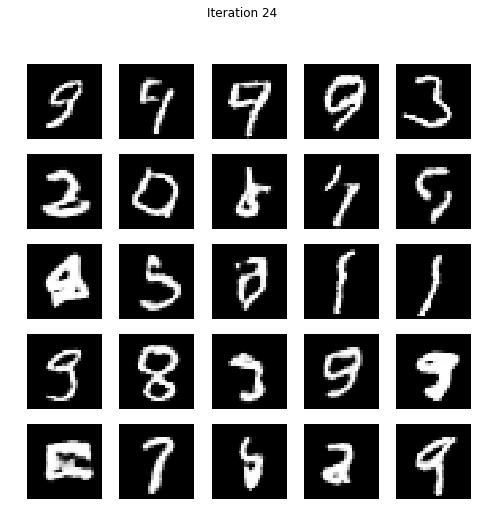

Epoch: 81; Disc loss = 0.688; Gen loss = 0.694
Epoch: 82; Disc loss = 0.687; Gen loss = 0.705
Epoch: 83; Disc loss = 0.685; Gen loss = 0.686
Epoch: 84; Disc loss = 0.684; Gen loss = 0.705
Epoch: 85; Disc loss = 0.684; Gen loss = 0.709
Epoch: 86; Disc loss = 0.683; Gen loss = 0.712
Epoch: 87; Disc loss = 0.693; Gen loss = 0.700
Epoch: 88; Disc loss = 0.693; Gen loss = 0.670
Epoch: 89; Disc loss = 0.687; Gen loss = 0.717
Epoch: 90; Disc loss = 0.686; Gen loss = 0.704
>Accuracy real: 22%, fake: 93%


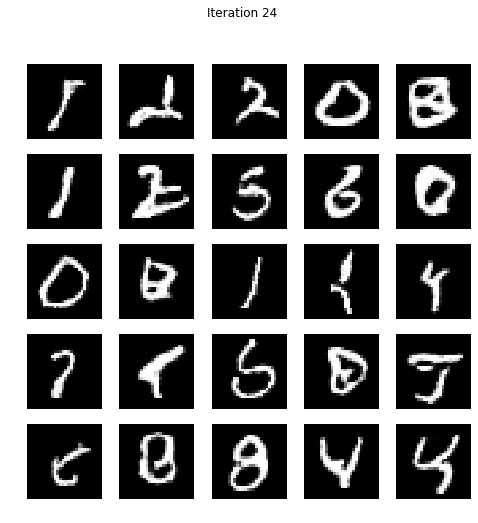

Epoch: 91; Disc loss = 0.687; Gen loss = 0.736
Epoch: 92; Disc loss = 0.686; Gen loss = 0.700
Epoch: 93; Disc loss = 0.693; Gen loss = 0.693
Epoch: 94; Disc loss = 0.695; Gen loss = 0.708
Epoch: 95; Disc loss = 0.686; Gen loss = 0.723
Epoch: 96; Disc loss = 0.691; Gen loss = 0.697
Epoch: 97; Disc loss = 0.691; Gen loss = 0.756
Epoch: 98; Disc loss = 0.689; Gen loss = 0.701
Epoch: 99; Disc loss = 0.693; Gen loss = 0.692
Epoch: 100; Disc loss = 0.692; Gen loss = 0.701
>Accuracy real: 20%, fake: 93%


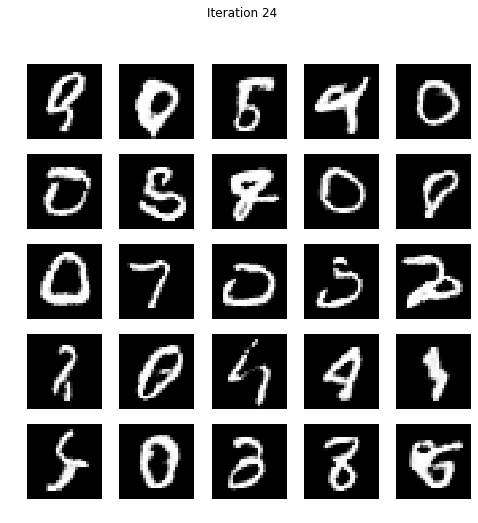

In [9]:
EPOCHS = 100
BS = 256
display_interval = 10
latent_dim = 100

bat_per_epo = int(x_train.shape[0] / BS)
half_batch = int(BS / 2)

# Manually enumerate epochs
for i in range(EPOCHS):
    # Enumerate batches over the training set
    for j in range(bat_per_epo):
        # Get randomly selected 'real' samples
        X_real, y_real = discriminator.generate_real_samples(x_train, half_batch)
        
        # Generate 'fake' examples
        X_fake, y_fake = generator.generate_fake_samples(latent_dim, half_batch)
        
        # Create training set for the discriminator
        X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
        
        # Update discriminator model weights
        d_loss, _ = discriminator.model.train_on_batch(X, y)
        
        # Prepare points in latent space as input for the generator
        X_gan = generator.generate_latent_points(latent_dim, BS)
        
        # Create inverted labels for the fake samples
        y_gan = np.zeros((BS, 1))
        
        # Update the generator via the discriminator's error
        g_loss = gan.model.train_on_batch(X_gan, y_gan)
    
    # Summarize loss on this epoch
    print('Epoch: %d; Disc loss = %.3f; Gen loss = %.3f' % (i + 1, d_loss, g_loss))
        
    # Evaluate the model performance
    if (i + 1) % display_interval == 0:
        gan.summarize_performance(i, x_train, latent_dim)
        
# Save model
generator.model.save('generator.model')